# 数据探索
主要完成**EDA**(探索式数据分析)和**可视化**

In [1]:
import pandas as pd
import time
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import math
pd.set_option('max_colwidth',200)
warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True)

In [2]:
data=pd.read_csv('./data/happiness_test_complete.csv',encoding='gbk')
data.fillna(-8)
data.head(5)

,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,8001,1,2,2,9,2015/7/24 10:30,2,1972,8,0,...,4,80,80.0,60,80,80,80,80,80,80
1,8002,1,22,66,106,2015/7/12 15:38,2,1938,1,1,...,5,90,80.0,80,80,80,80,70,80,80
2,8003,2,9,22,44,2015/7/5 9:36,2,1935,1,1,...,5,95,95.0,80,90,80,95,95,80,90
3,8004,2,18,52,86,2015/7/19 10:10,2,1992,1,1,...,4,80,80.0,70,90,80,80,70,60,50
4,8005,2,24,70,110,2015/8/3 11:41,1,1990,1,1,...,-8,60,50.0,0,30,40,50,60,-2,60


## 调整格式

In [3]:
data['survey_time'] = data['survey_time'].apply(lambda x: time.mktime(time.strptime(x,"%Y/%m/%d %H:%M")))
data = data.drop(["property_other","invest_other","edu_other"],axis=1)


In [4]:
def fillna(data,features):
    for i in range(len(features)):
        temp_operation_feature = features[i]                                    
        temp_mean= data[data[temp_operation_feature]>0][temp_operation_feature].mean()
        data[temp_operation_feature]=data[temp_operation_feature].apply(lambda x: temp_mean if x<0 or pd.isna(x) else x)
    data[temp_operation_feature].hist()
    return data

## 开始玩特征!
### 1.目标: happiness	 

That's allright

### 2. 采访地点

In [5]:
data['survey_type'].describe()

count    2968.000000
mean        1.422507
std         0.494042
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: survey_type, dtype: float64

province city county 能拼一起吗? city编号是各自的编号,还是在province里的编号?


那 province city就再见了

In [6]:
data = data.drop(['province','city'],axis=1)

### 3.问卷时间

个人感觉没用,再加上有个离群点

In [7]:
data = data.drop(['survey_time'],axis=1)

### 4.身体信息

### 5.年龄

我就是想把它变成年龄(但后面有归一化,所以这步完全是一点没用的)

In [8]:
data[['age']]=data[['birth']].apply(lambda x:2019-x)
data = data.drop('birth',axis=1)

### 6.民族
这里数值的相邻并不表示逻辑的相邻,按理应该One-hot,但我懒,所以干脆把少数民族都变成0,汉族为1

In [9]:
data['nationality'] = data['nationality'].apply(lambda x:1 if x==1 else 0)


### 7.宗教

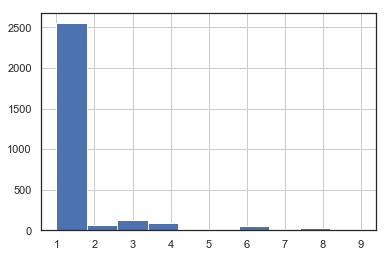

In [10]:
data = fillna(data,['religion','religion_freq'])

### 8.教育
教育程度edu可以直接用

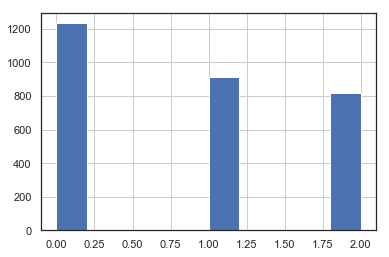

In [11]:
def temp_bagging(n):
    if pd.isna(n):
        return 0
    if n<500:
        return 0
    else:
        return round((n-1930)/40)
data['edu_yr'].apply(lambda x:temp_bagging(x)).hist()
data = data.drop('edu_yr',axis=1)

重排一下edu_status,大致按教育进度低到高

In [12]:
temp_dic={1:2,2:3,3:1,4:4}
data['edu_status'] = data['edu_status'].apply(lambda x :temp_dic[x] if 0<x<5 else 1)


### 9.收入
离散化操作,调整一下数据的形态

In [13]:
data['income']=data['income'].apply(lambda x:math.log(x) if x>0 else -1)

相当于做了一个分箱,这样正相关就更明显了

### 10.政治面貌
略微调整一下顺序.

In [14]:
temp_dic={1:1,2:2,3:4,4:3}
data['political'] = data['political'].apply(lambda x :temp_dic[x] if 0<x<5 else 1)

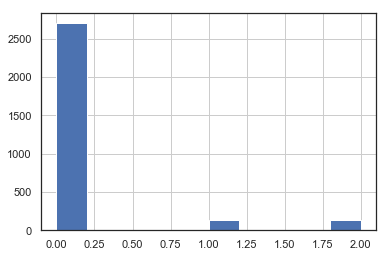

In [15]:
def temp_bagging(n):
    if pd.isna(n):
        return 0
    if n<500:
        return 0
    else:
        return round((n-1930)/40)
data['join_party'].apply(lambda x:temp_bagging(x)).hist()
data = data.drop('join_party',axis=1)

### 10.住房
面积特征需要一样的离散化操作,property_0~8可以直接用

In [16]:
data['floor_area']=data['floor_area'].apply(lambda x:math.log(x) if x>0 else -1)


### 11.健康
数据缺失的就丢到3里去

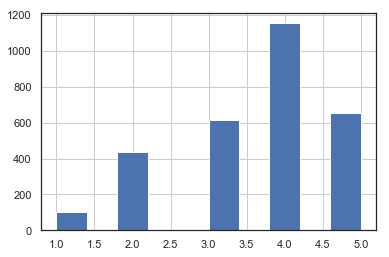

In [17]:
data = fillna(data,['health'])

health_problem没有说明,并且与health相关性高,于是drop掉

In [18]:
data = data.drop('health_problem',axis=1)

### 12.心情

这可是个好特征

### 13.户口
这个必须得one-hot了

In [19]:
temp = ['hukou_{}'.format(i) for i in range(1,9)]
for i in range(len(temp)):
    temp_operation_feature=temp[i]
    data[temp_operation_feature]=data['hukou'].apply(lambda x: 1 if x==i else 0)

In [20]:
data = data.drop('hukou',axis=1)

In [21]:
temp =  ['hukou_loc_{}'.format(i) for i in range(1,5)]
for i in range(len(temp)):
    temp_operation_feature=temp[i]
    data[temp_operation_feature]=data['hukou_loc'].apply(lambda x: 1 if x==i else 0)

In [22]:
data = data.drop('hukou_loc',axis=1)

### 14.娱乐与社交
检查一下就好了,缺的全部置中

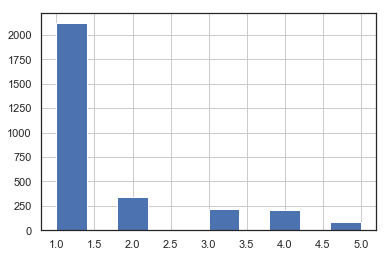

In [23]:
data = fillna(data,['media_{}'.format(i) for i in range(1,7)])

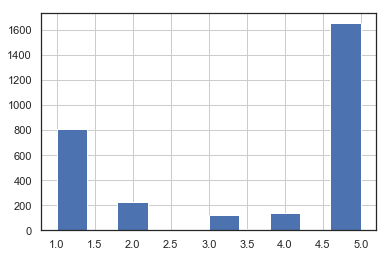

In [24]:
data = fillna(data,['leisure_{}'.format(i) for i in range(1,13)])

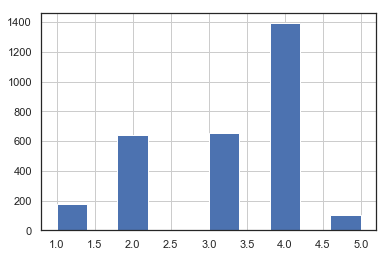

In [25]:
data = fillna(data,['socialize','relax','learn','social_neighbor','social_friend','socia_outing','equity'])

### 14.阶层
class
class_10_before
class_10_after
class_14
先填补缺失值

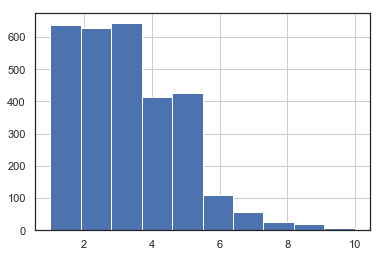

In [26]:
data = fillna(data,['class','class_10_before','class_10_after','class_14'])

In [27]:
data['class_10_after_rate'] = (data['class']/data['class_10_after'])
data['class_10_before_rate'] = (data['class']/data['class_10_before'])
data['class_14_rate'] = (data['class']/data['class_14'])

### 15. 工作
填补一下空值就好了

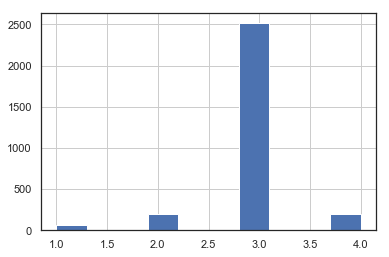

In [28]:
data = fillna(data,['work_exper','work_status','work_yr','work_type','work_manage'])

### 15. 社保
填补一下空值就好了

没有我以为的相关系数那么大...

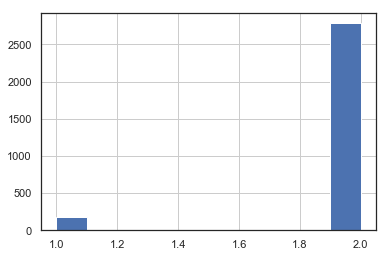

In [29]:
data = fillna(data,['insur_1','insur_2','insur_3','insur_4'])

为什么异常值调整了以后,相关系数都降那么多? -没解决的问题

### 16. 家庭情况
##### 16.1 收入
先计算人均收入,再取对数

In [30]:
data['family_income_per']=(data['family_income']/data['family_m']).apply(lambda x:math.log(x) if x>0 else -1)

然后来个组合变量,由于是取过对数,这里直接减了

In [31]:
data['income_rate']=data['family_income_per']-data['income']

In [32]:
data = data.drop(['family_income'],axis=1)

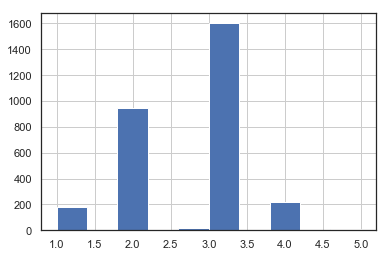

In [33]:
data = fillna(data,['family_status'])

#### 16.2 房,车
负房产? 直接装袋

In [34]:
def temp_bagging(n):
    if n>1:
        return 3
    if n>0:
        return 2
    else:
        return 1
data['house'] =data['house'].apply(lambda x:temp_bagging(x))


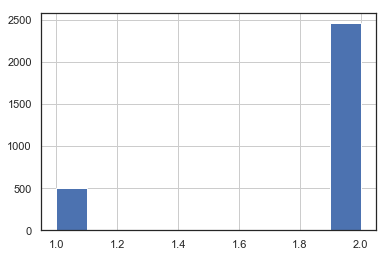

In [35]:
data=fillna(data,['car'])

#### 16.3 投资
已经one-hot了,fillna

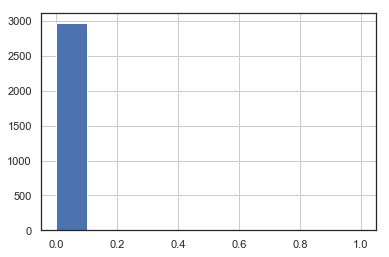

In [36]:
data=fillna(data,['invest_{}'.format(i) for i in range(9)])

#### 16.3 儿女
可能需要装一下袋

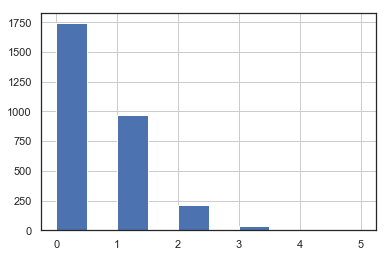

In [37]:
data=fillna(data,['son','daughter','minor_child'])

女儿令人快乐,儿子令人不快乐...(滑稽)

但还是别把两个特征和一起了

In [38]:
def temp_bagging(n):
    if n>1:
        return 3
    if n>0:
        return 2
    else:
        return 1
data['son'] =data['son'].apply(lambda x:temp_bagging(x))

In [39]:
def temp_bagging(n):
    if n>1:
        return 3
    if n>0:
        return 2
    else:
        return 1
data['daughter'] =data['daughter'].apply(lambda x:temp_bagging(x))

In [40]:
def temp_bagging(n):
    if n>1:
        return 3
    if n>0:
        return 2
    else:
        return 1
data['minor_child'] =data['minor_child'].apply(lambda x:temp_bagging(x))

### 16.4 婚姻

In [41]:
for temp_operation_feature in ['marital_{}'.format(i) for i in range(1,9)]:
    data[temp_operation_feature]=data['marital'].apply(lambda x: 1 if x==i else 0)
data = data.drop('marital',axis=1)

结婚时间不知道咋用,先分下袋吧

In [42]:
def temp_bagging(n):
    if pd.isna(n):
        return 0
    if n<500:
        return 0
    else:
        return round((n-1930)/10)
data['marital_1st'] = data['marital_1st'].apply(lambda x:temp_bagging(x))


In [43]:
def temp_bagging(n):
    if pd.isna(n):
        return 0
    if n<500:
        return 0
    else:
        return round((n-1930)/10)
data['marital_now'] = data['marital_now'].apply(lambda x:temp_bagging(x))


计算配偶年龄比

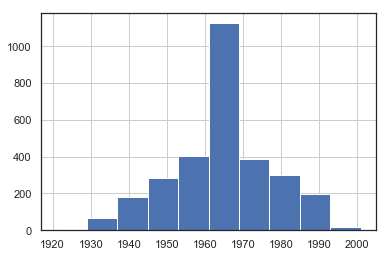

In [44]:
data =fillna(data,['s_birth'])

In [45]:
data['age_rate']=((2019-data['s_birth'])/data['age'])


配偶信息和本人的信息一样操作,然后稍微组合一下

In [46]:
temp_dic={1:1,2:2,3:4,4:3}
data['s_political'] = data['s_political'].apply(lambda x :temp_dic[x] if 0<x<5 else 1)

In [47]:
for temp_operation_feature in ['s_hukou_{}'.format(i) for i in range(1,9)]:
    data[temp_operation_feature]=data['s_hukou'].apply(lambda x: 1 if x==i else 0)
data = data.drop('s_hukou',axis=1)

In [48]:
data['s_income']=data['s_income'].apply(lambda x:math.log(x) if x>0 else -1)
data['s_income_rate']=data['s_income']-data['income']

#### 16.5 父母
组合一下吧

In [49]:
data['parents_age_rate']=abs((2019-data['f_birth'])-(2019-data['m_birth']))

temp_mean= data[data['parents_age_rate']<70]['parents_age_rate'].mean()
data['parents_age_rate']=data['parents_age_rate'].apply(lambda x: temp_mean if x>70 or pd.isna(x) else x)

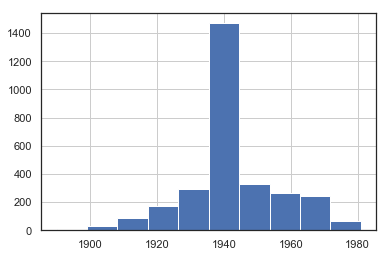

In [50]:
data =fillna(data,['f_birth','m_birth'])
data['f_older']=2019-data['f_birth']-data['age']
data['m_older']=2019-data['m_birth']-data['age']
data = data.drop(['f_birth','m_birth'],axis=1)

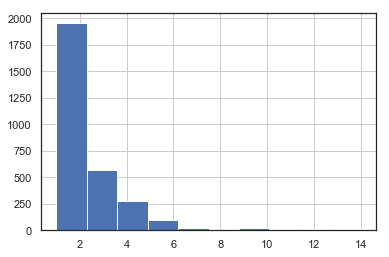

In [51]:
data =fillna(data,['f_edu','m_edu'])
data['parents_edu_rate']=abs(data['f_edu']-data['m_edu'])

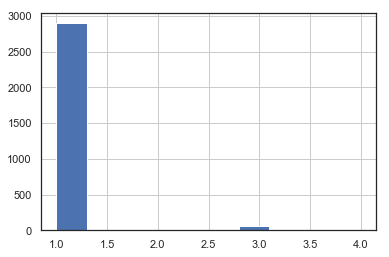

In [52]:
temp_dic={1:1,2:2,3:4,4:3}
data['f_political'] = data['f_political'].apply(lambda x :temp_dic[x] if 0<x<5 else 1)
data['m_political'] = data['m_political'].apply(lambda x :temp_dic[x] if 0<x<5 else 1)
data =fillna(data,['f_political','m_political'])

父母工作one-hot一下

In [53]:
temp = ['m_work_14_{}'.format(i) for i in range(1,18)]
for i in range(len(temp)):
    temp_operation_feature=temp[i]
    data[temp_operation_feature]=data['m_work_14'].apply(lambda x: 1 if x==i else 0)

In [54]:
temp = ['f_work_14_{}'.format(i) for i in range(1,18)]
for i in range(len(temp)):
    temp_operation_feature=temp[i]
    data[temp_operation_feature]=data['f_work_14'].apply(lambda x: 1 if x==i else 0)

### 17.现况满意

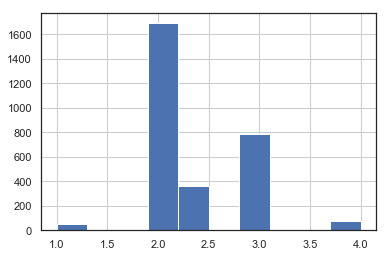

In [55]:
data =fillna(data,['status_peer','status_3_before','view','inc_ability'])

In [56]:
data['inc_exp']=data['inc_exp'].apply(lambda x:math.log(x) if x>0 else -1)

In [57]:
data['income_exp_rate']=data['inc_exp']-data['income']

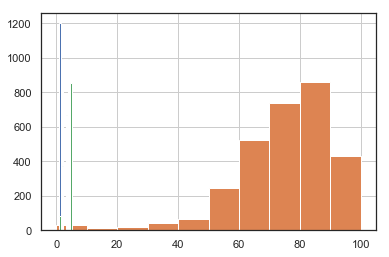

In [58]:
data =fillna(data,['trust_{}'.format(i) for i in range(1,14)])
data =fillna(data,['public_service_{}'.format(i) for i in range(1,10)])
data =fillna(data,['neighbor_familiarity'])

### 18.Id
不需要犹豫

In [59]:
data = data.drop("id",axis=1)

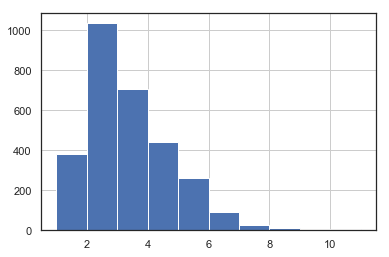

In [60]:
data=fillna(data,['s_work_type','depression','religion_freq','s_work_status','edu','s_edu','f_work_14','m_work_14','family_m'
])

## 保存一下

In [61]:
data.to_csv('./data/washed_test_data.csv')

In [62]:
data.describe().T.to_csv('./data/describe_test.csv')